<a href="https://colab.research.google.com/github/marco-siino/DA-BT/blob/main/BCI_RDWT_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets

!pip install mne
import scipy.io
import numpy as np
import pywt
import matplotlib.pyplot as plt
import mne



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.3 MB/s eta 0:00:00


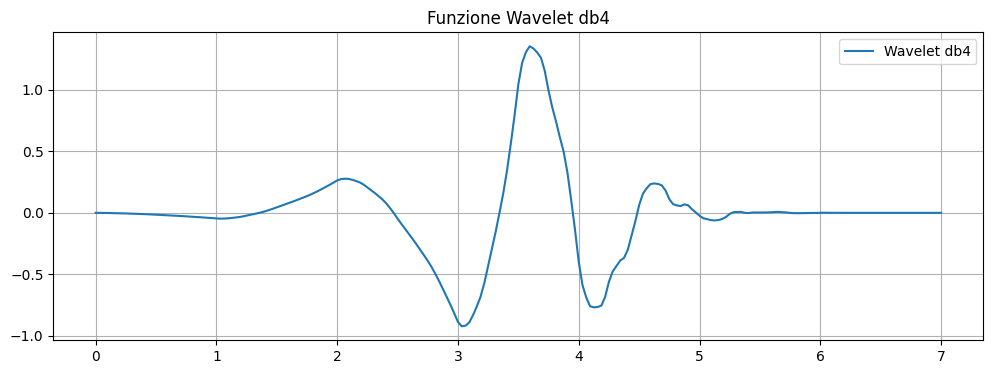

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

wavelet_name = 'db4'
wavelet = pywt.Wavelet(wavelet_name)

phi, psi, x = wavelet.wavefun(level=5)

plt.figure(figsize=(12, 4))
plt.plot(x, psi, label=f'Wavelet {wavelet_name}')
plt.title(f'Funzione Wavelet {wavelet_name}')
plt.legend()
plt.grid()
plt.show()


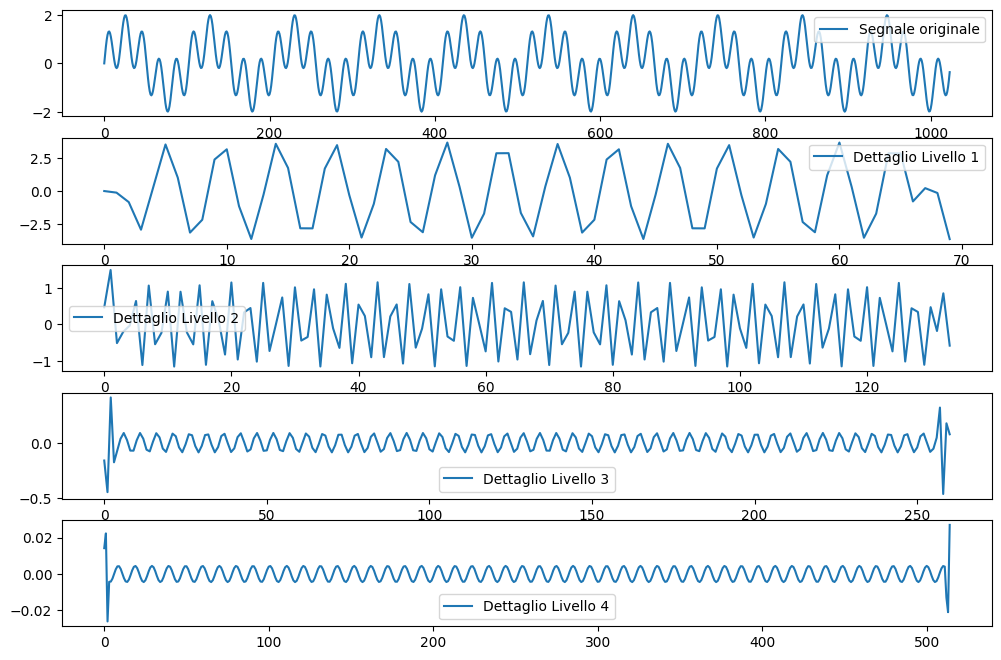

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Creiamo un segnale con due frequenze
t = np.linspace(0, 1, 1024, endpoint=False)
signal = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 50 * t)

# Decomposizione wavelet
wavelet = 'db4'
level = 4
coeffs = pywt.wavedec(signal, wavelet, level=level)

# Grafico della decomposizione
fig, axes = plt.subplots(level + 1, 1, figsize=(12, 8))
axes[0].plot(signal, label="Segnale originale")
axes[0].legend()
for i in range(1, level + 1):
    axes[i].plot(coeffs[i], label=f"Dettaglio Livello {i}")
    axes[i].legend()
plt.show()


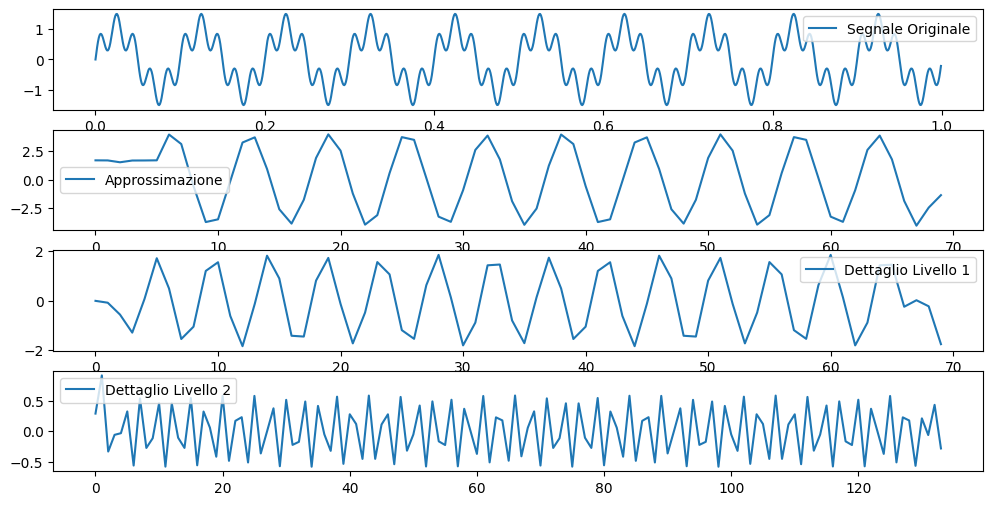

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Creiamo un segnale misto
t = np.linspace(0, 1, 1024, endpoint=False)
signal_original = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 50 * t)

# Applichiamo la Wavelet (DWT classica)
wavelet = 'db4'
coeffs = pywt.wavedec(signal_original, wavelet, level=4)
cA = coeffs[0]  # Coefficienti di approssimazione
cD1 = coeffs[1]  # Coefficienti di dettaglio livello 1
cD2 = coeffs[2]  # Coefficienti di dettaglio livello 2

# Plottiamo il segnale e i coefficienti
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(t, signal_original, label="Segnale Originale")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(cA, label="Approssimazione")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(cD1, label="Dettaglio Livello 1")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(cD2, label="Dettaglio Livello 2")
plt.legend()

plt.show()


# Definizione RDWT

In [ ]:
import numpy as np
import scipy.signal as signal
import pywt

def rational_dilated_wavelet_transform(sig, wavelet='db4', levels=4, dilation_factors=None, threshold=5.5):
    """
    Applica la Rational Dilated Wavelet Transform (RDWT) al segnale, eseguendo una decomposizione con dilatazione razionale.

    Args:
    - sig: il segnale da elaborare (numpy array)
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - levels: numero di livelli di decomposizione (default 4)
    - dilation_factors: fattori di dilatazione razionale per ogni livello (es. [3/2, 5/3, 7/4, ...])
    - threshold: soglia per i coefficienti di dettaglio (default 5.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """

    if dilation_factors is None:
        # Se non specificati, usa fattori di scala crescenti
        dilation_factors = [3/2, 5/3, 7/4, 9/5]

    coeffs_approx = sig  # Inizializza con il segnale originale
    detail_coeffs = []

    for i in range(levels):
        factor = dilation_factors[i]

        # Applica un filtro wavelet con fattore di dilatazione razionale
        wavelet_filter = pywt.Wavelet(wavelet)
        lo_d, hi_d = wavelet_filter.dec_lo, wavelet_filter.dec_hi

        # Ridimensiona i filtri per rispettare la scala razionale
        lo_d = signal.resample(lo_d, int(len(lo_d) * factor))
        hi_d = signal.resample(hi_d, int(len(hi_d) * factor))

        # Convoluzione per decomposizione
        approx = np.convolve(coeffs_approx, lo_d, mode='same')
        detail = np.convolve(coeffs_approx, hi_d, mode='same')

        # Soglia i coefficienti di dettaglio
        detail[np.abs(detail) < threshold] = 0

        # Salva il dettaglio e passa l'approssimazione al livello successivo
        detail_coeffs.append(detail)
        coeffs_approx = approx

    # Ricostruzione del segnale
    reconstructed = coeffs_approx
    for i in range(levels-1, -1, -1):
        reconstructed += detail_coeffs[i]  # Somma i dettagli per la ricostruzione

    return reconstructed


# Visualizzazione RDWT.

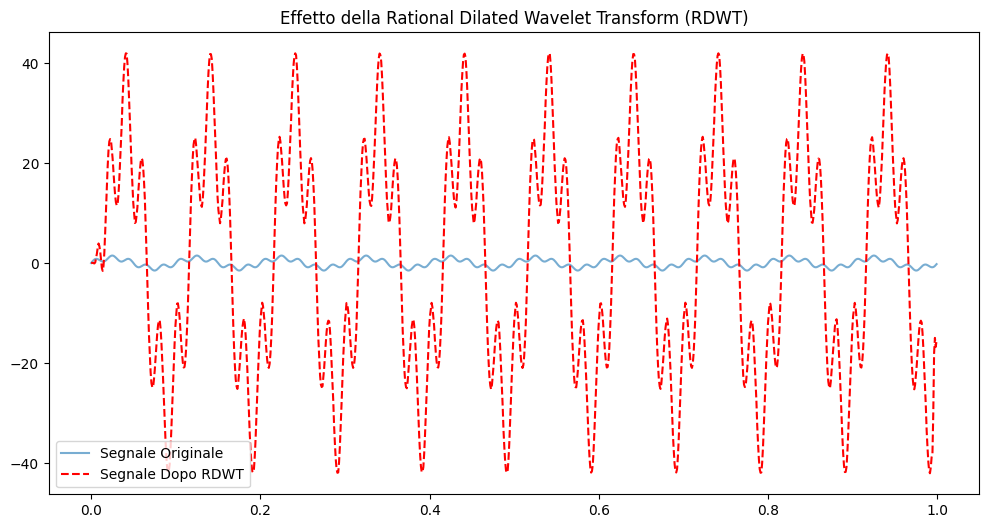

In [ ]:
import matplotlib.pyplot as plt

# Creiamo un segnale misto
t = np.linspace(0, 1, 1024, endpoint=False)
signal_original = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 50 * t)

# Applica la RDWT
signal_filtered = rational_dilated_wavelet_transform(signal_original, wavelet='db4', levels=4, threshold=0.5)

# Plot dei risultati
plt.figure(figsize=(12, 6))
plt.plot(t, signal_original, label="Segnale Originale", alpha=0.6)
plt.plot(t, signal_filtered, label="Segnale Dopo RDWT", linestyle="dashed", color='r')
plt.legend()
plt.title("Effetto della Rational Dilated Wavelet Transform (RDWT)")
plt.show()


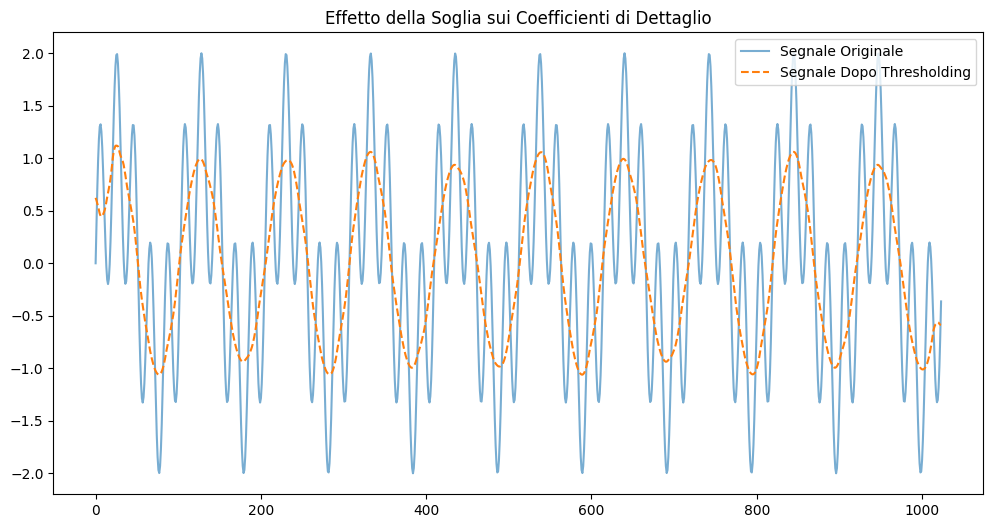

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Applichiamo la soglia ai coefficienti di dettaglio
threshold = 5.5
coeffs_thresholded = [coeffs[0]]
for i in range(1, len(coeffs)):
    coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

# Ricostruzione del segnale
reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet)

# Plot confronto
plt.figure(figsize=(12, 6))
plt.plot(signal, label="Segnale Originale", alpha=0.6)
plt.plot(reconstructed_signal, label="Segnale Dopo Thresholding", linestyle="dashed")
plt.legend()
plt.title("Effetto della Soglia sui Coefficienti di Dettaglio")
plt.show()


/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


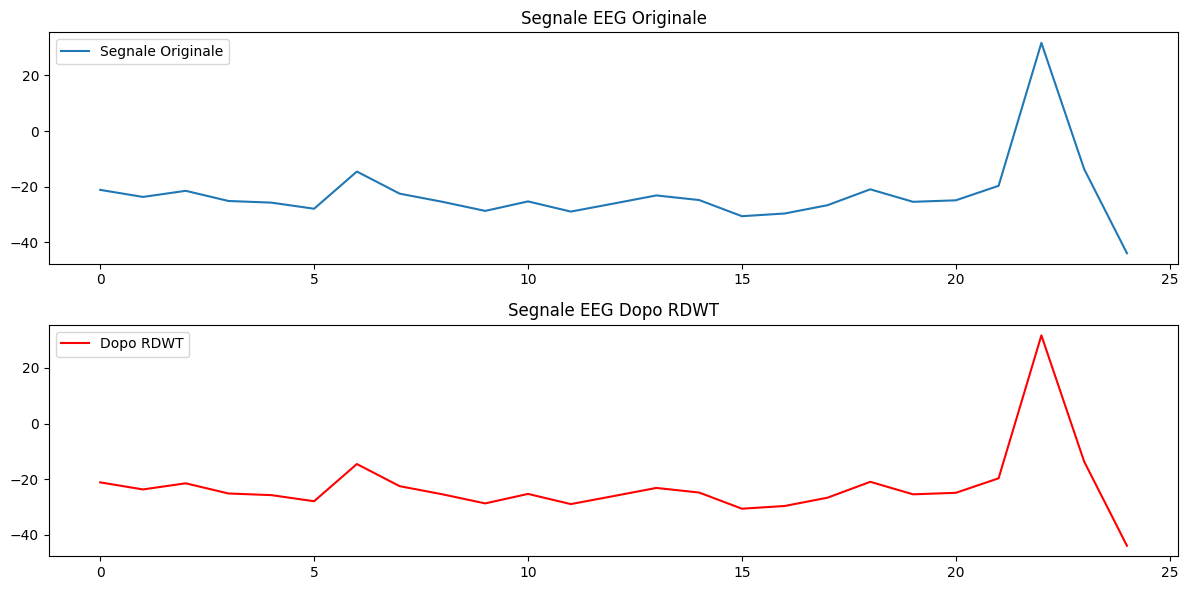

File preprocessato salvato come A01T_preprocessed.mat


In [ ]:
def apply_rdwt(signal, wavelet='db4', level=4):
    # Applica la RDWT al segnale e lo ricostruisce con la stessa dimensione
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    reconstructed = pywt.waverec(coeffs, wavelet, mode='per')

    # Taglia per mantenere la stessa lunghezza dell'input
    return reconstructed[:len(signal)]

# Caricare il file .mat
file_path = "A01T.mat"
mat_contents = scipy.io.loadmat(file_path)
data_entry = mat_contents['data'][0, 0]

# Estrarre il segnale EEG
eeg_data = data_entry['X'][0, 0]  # Controllo dimensioni

# Gestire sia il caso 2D che 3D
if len(eeg_data.shape) == 2:
    num_channels, num_timepoints = eeg_data.shape
    num_trials = 1  # Se non ci sono trial espliciti
    eeg_data = eeg_data[..., np.newaxis]  # Aggiunge una dimensione trial
else:
    num_channels, num_timepoints, num_trials = eeg_data.shape

# Applicare la RDWT a ogni canale e trial
processed_data = np.zeros_like(eeg_data)
for trial in range(num_trials):
    for ch in range(num_channels):
        processed_data[ch, :, trial] = apply_rdwt(eeg_data[ch, :, trial])

# Visualizzazione di un canale prima e dopo la RDWT
channel_to_plot = 0  # Seleziona un canale da visualizzare
trial_to_plot = 0  # Seleziona un trial
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(eeg_data[channel_to_plot, :, trial_to_plot], label="Segnale Originale")
plt.title("Segnale EEG Originale")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(processed_data[channel_to_plot, :, trial_to_plot], label="Dopo RDWT", color='r')
plt.title("Segnale EEG Dopo RDWT")
plt.legend()
plt.tight_layout()
plt.show()

# Salvare il nuovo file .mat mantenendo la struttura originale
data_entry['X'][0, 0] = processed_data if num_trials > 1 else processed_data.squeeze()
output_path = "A01T_preprocessed.mat"
scipy.io.savemat(output_path, {'data': mat_contents['data']})

print(f"File preprocessato salvato come {output_path}")

In [ ]:
print(mat_contents['data'][0,0][0])

[(array([[-21.14257813, -23.68164063, -21.484375  , ...,  31.73828125,
         -13.671875  , -43.9453125 ],
        [-21.92382813, -23.92578125, -24.31640625, ...,  22.4609375 ,
         -13.18359375, -40.52734375],
        [-15.625     , -19.7265625 , -18.84765625, ...,  33.69140625,
          -8.30078125, -38.57421875],
        ...,
        [-26.41601563, -17.52929688, -17.28515625, ..., -14.6484375 ,
         -40.52734375, -19.53125   ],
        [-31.98242188, -16.65039063, -21.72851563, ..., -11.71875   ,
         -48.33984375, -12.6953125 ],
        [-33.984375  , -22.4609375 , -23.92578125, ...,  -7.8125    ,
         -42.96875   ,  -9.27734375]]), array([], shape=(0, 1), dtype=uint8), array([], shape=(0, 1), dtype=uint8), array([[250]], dtype=uint8), array([[array(['left hand'], dtype='<U9'),
         array(['right hand'], dtype='<U10'),
         array(['feet'], dtype='<U4'), array(['tongue'], dtype='<U6')]],
       dtype=object), array([], shape=(0, 1), dtype=uint8), array(['f

In [ ]:
mat_contents = scipy.io.loadmat(file_path)
data_entry = mat_contents['data'][0, 0]

# Estrarre il segnale EEG
eeg_data = data_entry['X'][0, 0]

In [ ]:
print(len(mat_contents))

4


In [ ]:
print((mat_contents['data'][0][0][0][0][0]))

[[-21.14257812 -23.68164062 -21.484375   ...  31.73828125 -13.671875
  -43.9453125 ]
 [-21.92382812 -23.92578125 -24.31640625 ...  22.4609375  -13.18359375
  -40.52734375]
 [-15.625      -19.7265625  -18.84765625 ...  33.69140625  -8.30078125
  -38.57421875]
 ...
 [-26.41601562 -17.52929688 -17.28515625 ... -14.6484375  -40.52734375
  -19.53125   ]
 [-31.98242188 -16.65039062 -21.72851562 ... -11.71875    -48.33984375
  -12.6953125 ]
 [-33.984375   -22.4609375  -23.92578125 ...  -7.8125     -42.96875
   -9.27734375]]


In [ ]:
# Applicare la RDWT a ogni canale e trial
processed_data = np.zeros_like(eeg_data)
for trial in range(num_trials):
    for ch in range(num_channels):
        processed_data[:, trial] = apply_rdwt(eeg_data[ :, trial])

In [ ]:
print(processed_data[1])

[-21.92382812   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]


In [ ]:
mat_contents = scipy.io.loadmat(file_path)

In [ ]:
# Qui visualizzo la dimensione che è 29683 valori temporali, per 25 canali.
print((mat_contents['data'][0][0][0][0][0]).shape)

(29683, 25)


In [ ]:
# Qui visualizzo il primo valore per ognuno dei 25 canali. (e difatti sono tutti simili)
print((mat_contents['data'][0][0][0][0][0]))

[[-21.14257812 -23.68164062 -21.484375   ...  31.73828125 -13.671875
  -43.9453125 ]
 [-21.92382812 -23.92578125 -24.31640625 ...  22.4609375  -13.18359375
  -40.52734375]
 [-15.625      -19.7265625  -18.84765625 ...  33.69140625  -8.30078125
  -38.57421875]
 ...
 [-26.41601562 -17.52929688 -17.28515625 ... -14.6484375  -40.52734375
  -19.53125   ]
 [-31.98242188 -16.65039062 -21.72851562 ... -11.71875    -48.33984375
  -12.6953125 ]
 [-33.984375   -22.4609375  -23.92578125 ...  -7.8125     -42.96875
   -9.27734375]]


# In original signal ci sono 29 mila e qualcosa eventi temporali. a ognuno di questi eventi corrisponde un array con 25 valori (che corrispondono ai 25 canali). Ergo se voglio tutti i dati temporali di un canale, devo prendere il primo valore di ognuno dei 29 mila array.

[-21.14257812 -21.92382812 -15.625      ... -26.41601562 -31.98242188
 -33.984375  ]


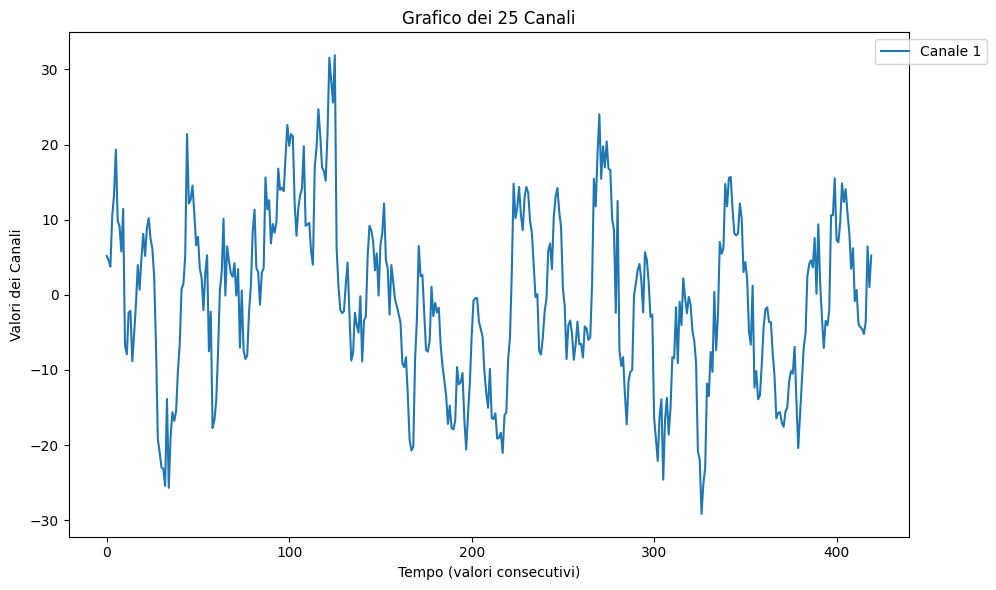

In [ ]:
original_signal = mat_contents['data'][0][0][0][0][0]
#print(original_signal)
# Con la riga seguente prendo tutti i valori temporali esclusivamente relativi al primo elemento (ovvero il primo canale)
print(original_signal[:,0])
original_signal_ch1 = original_signal[:,0]
preprocessed_signal_ch1 = apply_rdwt(original_signal_ch1)
# Creiamo un plot per visualizzare tutti i canali
plt.figure(figsize=(10, 6))

# Ogni canale è una colonna nella matrice 'data'
#for i in range(data.shape[1]):
    #plt.plot(data[:, i], label=f'Canale {i+1}')

plt.plot(original_signal_ch1[5000:5420], label=f'Canale {1}')


plt.title('Grafico dei 25 Canali')
plt.xlabel('Tempo (valori consecutivi)')
plt.ylabel('Valori dei Canali')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

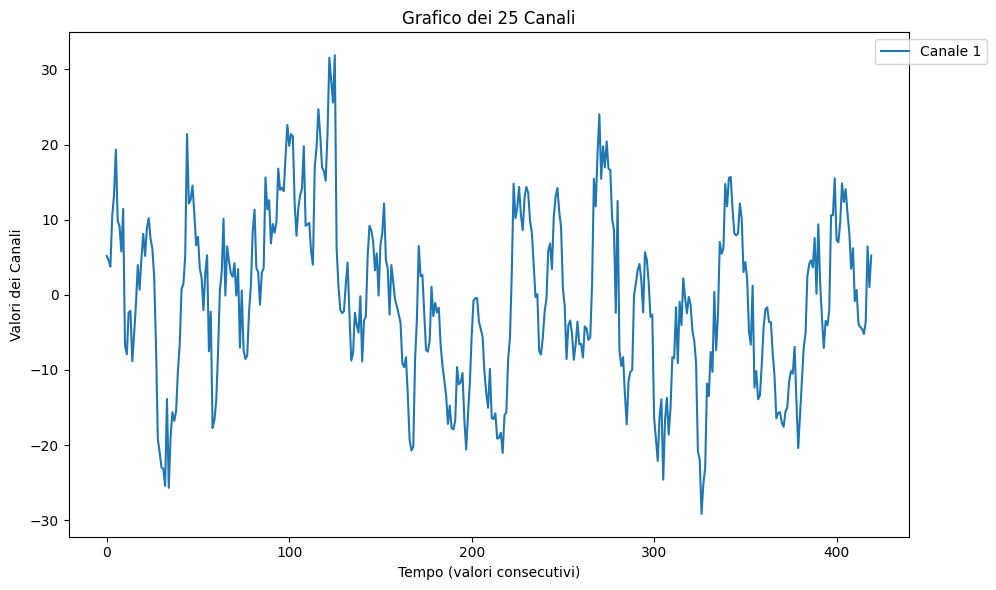

In [ ]:
# Creiamo un plot per visualizzare tutti i canali
plt.figure(figsize=(10, 6))
plt.plot(preprocessed_signal_ch1[5000:5420], label=f'Canale {1}')

plt.title('Grafico dei 25 Canali')
plt.xlabel('Tempo (valori consecutivi)')
plt.ylabel('Valori dei Canali')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

In [ ]:
def apply_rdwt(signal, wavelet='db4', level=4, threshold=10.5):
    """
    Applica la RDWT (Discrete Wavelet Transform) al segnale e lo ricostruisce,
    rimuovendo i coefficienti di dettaglio sotto una certa soglia per enfatizzare
    le caratteristiche principali del segnale.

    Args:
    - signal: il segnale da elaborare
    - wavelet: tipo di wavelet da utilizzare (default 'db4')
    - level: livello della decomposizione (default 4)
    - threshold: soglia per i coefficienti di dettaglio (default 0.5)

    Returns:
    - Il segnale ricostruito dopo la manipolazione della RDWT
    """

    # Decomposizione del segnale in coefficienti
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Modifica i coefficienti di dettaglio
    # Si applica un threshold sui coefficienti di dettaglio per "ridurre" la componente di alta frequenza
    coeffs_thresholded = [coeffs[0]]  # Mantieni il coefficiente di approssimazione
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(np.where(np.abs(coeffs[i]) < threshold, 0, coeffs[i]))

    # Ricostruzione del segnale dai coefficienti modificati
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    # Taglia il segnale ricostruito per mantenerne la stessa lunghezza dell'input
    return reconstructed_signal[:len(signal)]


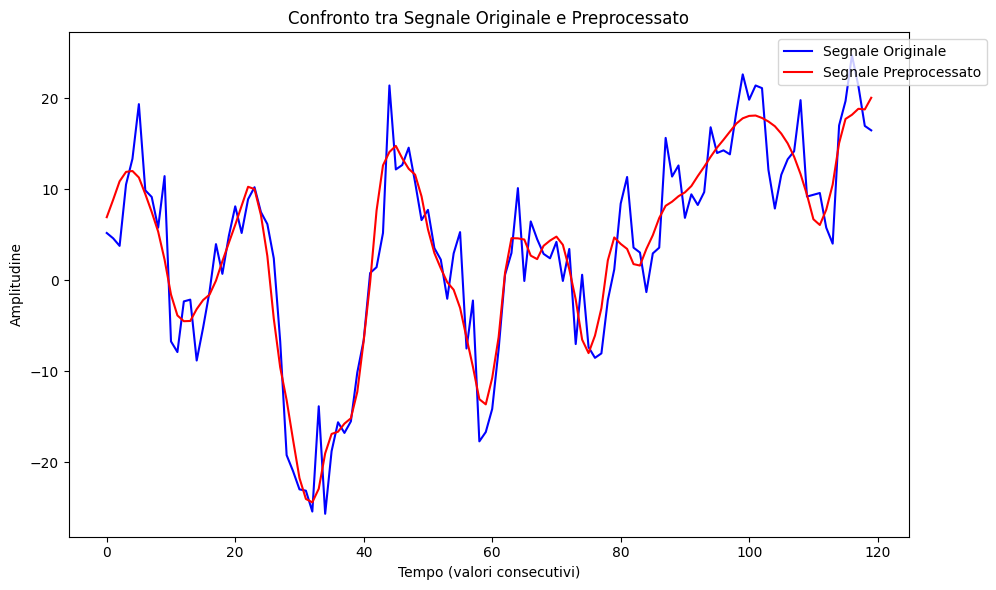

In [ ]:
original_signal = mat_contents['data'][0][0][0][0][0]
# Estrai i segnali per il confronto
original_signal_ch1 = original_signal[:, 0]  # Primo canale del segnale originale
preprocessed_signal_ch1 = apply_rdwt(original_signal_ch1)  # Segnale preprocessato

# Crea un plot che confronta i due segnali
plt.figure(figsize=(10, 6))

# Plot del segnale originale
plt.plot(original_signal_ch1[5000:5120], label='Segnale Originale', color='blue')

# Plot del segnale preprocessato
plt.plot(preprocessed_signal_ch1[5000:5120], label='Segnale Preprocessato', color='red')

# Aggiungi il titolo e le etichette degli assi
plt.title('Confronto tra Segnale Originale e Preprocessato')
plt.xlabel('Tempo (valori consecutivi)')
plt.ylabel('Amplitudine')

# Aggiungi la legenda
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

# Ottimizza la disposizione
plt.tight_layout()

# Mostra il grafico
plt.show()


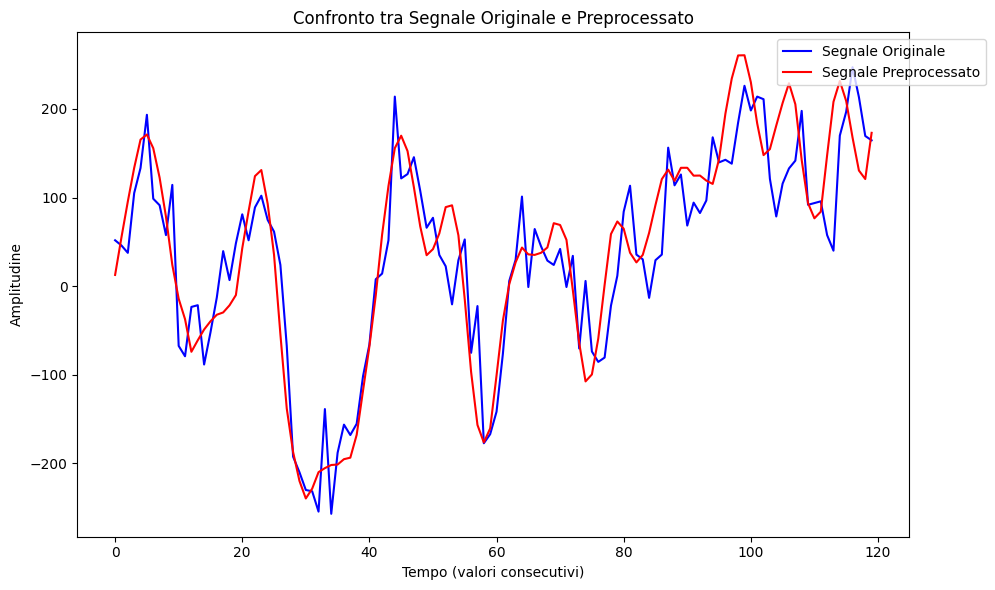

In [ ]:
original_signal = mat_contents['data'][0][0][0][0][0]
# Estrai i segnali per il confronto
original_signal_ch1 = original_signal[:, 0]  # Primo canale del segnale originale
preprocessed_signal_ch1 = rational_dilated_wavelet_transform(original_signal_ch1, wavelet='db4', levels=3, threshold=5.5)  # Segnale preprocessato

# Crea un plot che confronta i due segnali
plt.figure(figsize=(10, 6))

# Plot del segnale originale
plt.plot(original_signal_ch1[5000:5120]*10, label='Segnale Originale', color='blue')

# Plot del segnale preprocessato
plt.plot(preprocessed_signal_ch1[5012:5132], label='Segnale Preprocessato', color='red')

# Aggiungi il titolo e le etichette degli assi
plt.title('Confronto tra Segnale Originale e Preprocessato')
plt.xlabel('Tempo (valori consecutivi)')
plt.ylabel('Amplitudine')

# Aggiungi la legenda
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

# Ottimizza la disposizione
plt.tight_layout()

# Mostra il grafico
plt.show()
